In [1]:
import gc
import os
import random
from typing import List, Tuple

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_covtype
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
from tqdm.notebook import tqdm

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

In [5]:
def find_best_rf(X: np.ndarray, y: np.ndarray) -> RandomForestClassifier:
    space = [
        Real(0.000001, 0.01, 'log-uniform', name='ccp_alpha'),
        Real(0.5, 0.8, 'uniform', name='max_features'),
        Real(0.6, 0.9, 'uniform', name='max_samples'),
        Integer(50, 500, name='n_estimators')
    ]
    
    @use_named_args(space)
    def objective_f(ccp_alpha: float, max_features: float,
                    max_samples: float, n_estimators: int) -> float:
        test_cls = RandomForestClassifier(
            min_samples_leaf=5, n_estimators=n_estimators,
            random_state=42, verbose=True, n_jobs=-1,
            ccp_alpha=ccp_alpha, oob_score=True, bootstrap=True,
            max_samples=max_samples, max_features=max_features,
        )
        test_cls.fit(X, y)
        nd = len(test_cls.oob_decision_function_.shape)
        if nd != 2:
            err_msg = f'`oob_decision_function_` is wrong! ' \
                      f'Expected 2-D array, got {nd}-D one!'
            raise ValueError(err_msg)
        filtered = list(
            filter(
                lambda idx: not any(np.isnan(
                    test_cls.oob_decision_function_[idx]
                )),
                range(y.shape[0])
            )
        )
        info_msg = f'OOB score is estimated using {len(filtered)} ' \
                   f'samples from {y.shape[0]}.'
        print(info_msg)
        if len(filtered) < 3:
            err_msg = 'OOB score cannot be estimated!'
            raise ValueError(err_msg)
        quality = f1_score(
            y_true=y[filtered],
            y_pred=np.argmax(test_cls.oob_decision_function_[filtered],
                             axis=-1),
            average='macro'
        )
        return -quality
    
    res_gp = gp_minimize(
        objective_f, space,
        n_calls=32, n_random_starts=8,
        n_restarts_optimizer=4, random_state=42,
        verbose=True, n_jobs=1
    )
    best_parameters = {
        'ccp_alpha': float(res_gp.x[0]),
        'max_features': float(res_gp.x[1]),
        'max_samples': float(res_gp.x[2]),
        'n_estimators': int(res_gp.x[3]),
    }
    print(f'Best parameters are: {best_parameters}')
    final_cls = RandomForestClassifier(
        min_samples_leaf=5, random_state=42, verbose=True, n_jobs=-1,
        oob_score=True, bootstrap=True,
        ccp_alpha=best_parameters['ccp_alpha'],
        n_estimators=best_parameters['n_estimators'],
        max_samples=best_parameters['max_samples'],
        max_features=best_parameters['max_features'],
    )
    final_cls.fit(X, y)
    return final_cls

In [6]:
def build_preprocessor(X: np.ndarray, colnames: List[str]) -> Tuple[Pipeline, List[str], \
                                                                    List[int]]:
    X_ = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'scaler',
            MinMaxScaler()
        )
    ]).fit_transform(X)
    X_ = np.rint(X_ * 100000.0).astype(np.int32)
    binary_features = dict()
    categorical_features = dict()
    removed_features = []
    for col_idx in range(X.shape[1]):
        values = set(X_[:, col_idx].tolist())
        print(f'Column {col_idx} "{colnames[col_idx]}" has ' \
              f'{len(values)} unique values.')
        if len(values) > 1:
            if len(values) < 3:
                binary_features[col_idx] = np.min(X[:, col_idx])
            else:
                categorical_features[col_idx] = len(values)
        else:
            removed_features.append(col_idx)
        del values
    del X_
    all_features = set(range(X.shape[1]))
    useful_features = sorted(list(all_features - set(removed_features)))
    if len(useful_features) == 0:
        raise ValueError('Training inputs are bad. All features are removed.')
    print(f'There are {X.shape[1]} features.')
    if len(removed_features) > 0:
        print(f'These features will be removed: ' \
              f'{[colnames[col_idx] for col_idx in removed_features]}.')
    transformers = []
    if (len(categorical_features) > 0) and (len(binary_features) > 0):
        print(f'There are {len(categorical_features)} categorical ' \
              f'features and {len(binary_features)} binary features.')
    elif len(categorical_features) > 0:
        print(f'There are {len(categorical_features)} categorical features.')
    else:
        print(f'There are {len(binary_features)} binary features.')
    source_features = []
    for col_idx in categorical_features:
        n_unique_values = categorical_features[col_idx]
        transformers.append(
            (
                colnames[col_idx],
                KBinsDiscretizer(
                    n_bins=min(max(n_unique_values // 3, 3), 256),
                    encode='ordinal',
                    strategy=('quantile' if n_unique_values > 50 else 'kmeans')
                ),
                (col_idx,)
            )
        )
        source_features.append(colnames[col_idx])
    for col_idx in binary_features:
        transformers.append(
            (
                colnames[col_idx],
                Binarizer(threshold=0.0),
                (col_idx,)
            )
        )
        source_features.append(colnames[col_idx])
    preprocessor = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'minmax_scaler',
            MinMaxScaler()
        ),
        (
            'composite_transformer', ColumnTransformer(
                transformers=transformers,
                sparse_threshold=0.0,
                n_jobs=1
            )
        ),
        (
            'selector',
            VarianceThreshold()
        )
    ])
    preprocessor.fit(X)
    mask = preprocessor.named_steps['selector'].get_support(indices=False)
    assert len(mask) == len(source_features)
    selected_features = list(map(
        lambda idx2: source_features[idx2],
        filter(lambda idx1: mask[idx1], range(len(mask)))
    ))
    X_trans = preprocessor.transform(X)
    assert X_trans.shape[1] == len(selected_features)
    unique_values_list = []
    for ft_idx in range(X_trans.shape[1]):
        unique_values = set(map(lambda it: int(it), X_trans[:, ft_idx].tolist()))
        n_unique_values = len(unique_values)
        assert n_unique_values > 1
        unique_values_list.append(n_unique_values)
    return preprocessor, selected_features, unique_values_list

In [7]:
def build_normalizer(X: np.ndarray) -> Pipeline:
    normalizer = Pipeline(steps=[
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'standard_scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=42)
        )
    ])
    return normalizer.fit(X)

In [ ]:
def generate_initializer():
    try:
        kernel_initializer = tf.keras.initializers.GlorotNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.glorot_normal(
            seed=random.randint(0, 2147483647)
        )
    return kernel_initializer

In [8]:
def build_neural_network(features: List[int], n_classes: int,
                         n_latent: int, n_hidden: int, depth: int,
                         nn_name: str) -> Tuple[tf.keras.Model, tf.keras.Model, \
                                                tf.keras.Model]:
    if n_hidden < 1:
        err_msg = f'The hidde layer size = {n_hidden} is too small!'
    binary_ft_indices = set()
    for ft_idx, ft_size in enumerate(features):
        if ft_size < 2:
            err_msg = f'Feature {ft_idx} unique values quanity = {ft_size} is too small!'
            raise ValueError(err_msg)
        if ft_size == 2:
            binary_ft_indices.add(ft_idx)
    if (len(binary_ft_indices) > 0) and (len(binary_ft_indices) < len(features)):
        info_msg = f'There are {len(binary_ft_indices)} binary features and ' \
                   f'{len(features) - len(binary_ft_indices)} categorical features.'
    elif len(binary_ft_indices) > 0:
        info_msg = f'There are {len(binary_ft_indices)} binary features.'
    else:
        info_msg = f'There are {len(features)} categorical features.'
    print(info_msg)
    feature_vector = tf.keras.layers.Input(
        shape=(len(features),), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    block_input = feature_vector
    for layer_idx in range(depth):
        first_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx * 3 + 1}'
        )(block_input)
        second_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx * 3 + 2}'
        )(first_layer)
        third_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx * 3 + 3}'
        )(second_layer)
        encoder_layer = tf.keras.layers.Add(
            name=f'{nn_name}_enc_add{layer_idx + 1}'
        )([first_layer, third_layer])
        block_input = encoder_layer
        del first_layer, second_layer, third_layer
    del block_input
    prior = tfp.distributions.Independent(
        distribution=tfp.distributions.Normal(
            loc=tf.zeros(n_latent),
            scale=1
        ),
        reinterpreted_batch_ndims=1
    )
    latent_layer = tf.keras.layers.Dense(
        units=tfp.layers.IndependentNormal.params_size(n_latent),
        activation=None,
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=f'{nn_name}_latent'
    )(encoder_layer)
    z = tfp.layers.IndependentNormal(
        event_shape=n_latent,
        convert_to_tensor_fn=tfp.distributions.Distribution.sample,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(
            distribution_b=prior,
            weight=1e-3
        ),
        name=f'{nn_name}_z'
    )(latent_layer)
    classifier_input = tf.keras.layers.Input(
        shape=(n_latent,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    hidden_layer = tf.keras.layers.Dense(
        units=n_hidden,
        activation='tanh',
        kernel_initializer=generate_initializer(),
        bias_initializer='zeros',
        name=f'{nn_name}_cls_hidden'
    )(classifier_input)
    cls_layer = tf.keras.layers.Dense(
        units=n_classes,
        activation='softmax',
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_cls_output'
    )(hidden_layer)
    cls_name = f'{nn_name}_cls'
    cls_model = tf.keras.Model(
        inputs=classifier_input,
        outputs=cls_layer,
        name=cls_name
    )
    cls_model.build(input_shape=[None, n_latent])
    block_input = z
    for layer_idx in range(depth):
        first_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx * 3 + 1}'
        )(block_input)
        second_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx * 3 + 2}'
        )(first_layer)
        third_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='tanh',
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx * 3 + 3}'
        )(second_layer)
        decoder_layer = tf.keras.layers.Add(
            name=f'{nn_name}_dec_add{layer_idx + 1}'
        )([first_layer, third_layer])
        block_input = decoder_layer
        del first_layer, second_layer, third_layer  
    reconstruction_layers = []
    reconstruction_names = []
    if len(binary_ft_indices) > 0:
        new_reconstruction_layer = tf.keras.layers.Dense(
            units=len(binary_ft_indices),
            activation=None,
            kernel_initializer=generate_initializer(),
            bias_initializer='zeros',
            name=f'{nn_name}_rec_binary'
        )(decoder_layer)
        new_reconstruction_name = f'{nn_name}_bernoulli'
        new_reconstruction_layer = tfp.layers.IndependentBernoulli(
            event_shape=len(binary_ft_indices),
            convert_to_tensor_fn=tfp.distributions.Bernoulli.logits,
            name=new_reconstruction_name
        )(new_reconstruction_layer)
        reconstruction_layers.append(new_reconstruction_layer)
        reconstruction_names.append(new_reconstruction_name)
    counter = 1
    for ft_idx, ft_size in enumerate(features):
        if ft_size > 2:
            new_reconstruction_layer = tf.keras.layers.Dense(
                units=ft_size,
                activation=None,
                kernel_initializer=generate_initializer(),
                bias_initializer='zeros',
                name=f'{nn_name}_rec_cat{counter}'
            )(decoder_layer)
            new_reconstruction_name = f'{nn_name}_categorical{counter}'
            new_reconstruction_layer = tfp.layers.OneHotCategorical(
                event_size=ft_size,
                convert_to_tensor_fn=tfp.distributions.OneHotCategorical.logits,
                name=new_reconstruction_name
            )(new_reconstruction_layer)
            reconstruction_layers.append(new_reconstruction_layer)
            reconstruction_names.append(new_reconstruction_name)
            counter += 1
    encoder_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=z,
        name=f'{nn_name}_enc'
    )
    united_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=[cls_model(z)] + reconstruction_layers,
        name=f'{nn_name}_vae'
    )
    encoder_model.build(input_shape=[None, len(features)])
    metrics = {cls_name: [tf.keras.metrics.CategoricalAccuracy()]}
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    losses = {
        cls_name: tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
    }
    loss_weights = {
        cls_name: 1.0
    }
    for cur_name in reconstruction_names:
        losses[cur_name] = negloglik
        loss_weights[cur_name] = 0.5
    radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    united_model.compile(optimizer=ranger, loss=losses,
                         loss_weights=loss_weights, metrics=metrics)
    return united_model, encoder_model, cls_model

In [9]:
def calculate_projections(X: np.ndarray, encoder: tf.keras.Model,
                          n_samples: int, batch_size: int) -> List[np.ndarray]:
    n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
    projections = [[] for _ in range(n_samples)]
    for batch_idx in tqdm(list(range(n_batches))):
        batch_start = batch_idx * batch_size
        batch_end = min(X.shape[0], batch_start + batch_size)
        distr = encoder(X[batch_start:batch_end])
        assert isinstance(distr, tfp.distributions.Distribution)
        if n_samples > 1:
            y_inst = distr.sample()
            if not isinstance(y_inst, np.ndarray):
                y_inst = y_inst.numpy()
            assert len(y_inst.shape) == 2
            projections[0].append(y_inst)
            del y_inst
            for prj_idx in range(1, n_samples):
                y_inst = distr.sample()
                if not isinstance(y_inst, np.ndarray):
                    y_inst = y_inst.numpy()
                assert len(y_inst.shape) == 2
                projections[prj_idx].append(y_inst)
                del y_inst
        else:
            y_inst = distr.mean()
            if not isinstance(y_inst, np.ndarray):
                y_inst = y_inst.numpy()
            assert len(y_inst.shape) == 2
            projections[0].append(y_inst)
            del y_inst
        del distr
    return [np.vstack(cur) for cur in projections]

In [10]:
def predict_proba(X: np.ndarray, encoder: tf.keras.Model, classifier: tf.keras.Model,
                  n_samples: int, batch_size: int) -> np.ndarray:
    projections = calculate_projections(X, encoder, n_samples, batch_size)
    y = classifier.predict(projections[0], batch_size=batch_size)
    assert len(y.shape) == 2
    for prj_idx in range(1, n_samples):
        y += classifier.predict(projections[prj_idx], batch_size=batch_size)
    proba = y.astype(np.float64) / float(n_samples)
    return proba / np.sum(proba, axis=1, keepdims=True)

In [11]:
class TrainsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_src: np.ndarray, x_norm: np.ndarray, y: np.ndarray,
                 n_classes: int, batch_size: int, features: List[int]):
        self.x_src, self.x_norm, self.y = x_src, x_norm, y
        self.batch_size = batch_size
        self.features = features
        self.n_classes = n_classes
        self.indices_ = np.array(list(range(self.x_src.shape[0])), dtype=np.int32)
        self.binary_feature_list_ = []
        self.cat_feature_list_ = []
        for ft_idx, ft_size in enumerate(self.features):
            if ft_size < 2:
                err_msg = f'Feature {ft_idx} unique values quanity = {ft_size} ' \
                          f'is too small!'
                raise ValueError(err_msg)
            if ft_size == 2:
                self.binary_feature_list_.append(ft_idx)
            else:
                self.cat_feature_list_.append(ft_idx)
        self.class_distr_ = dict()
        for sample_idx, class_idx in enumerate(y.tolist()):
            if class_idx in self.class_distr_:
                self.class_distr_[class_idx].append(sample_idx)
            else:
                self.class_distr_[class_idx] = [sample_idx]
        for class_idx in self.class_distr_:
            self.class_distr_[class_idx] = np.array(self.class_distr_[class_idx],
                                                    dtype=np.int32)
        assert len(self.x_src.shape) == 2
        assert self.x_src.shape[0] > self.batch_size
        assert self.x_norm.shape == self.x_src.shape
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x_src.shape[0]
        assert self.x_src.shape[1] == len(self.features)
    
    def __len__(self):
        return int(np.ceil(self.x_src.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_indices = []
        selected_classes = sorted(list(self.class_distr_.keys()))
        if self.batch_size < len(selected_classes):
            selected_classes = random.sample(selected_classes, self.batch_size)
        for counter, class_idx in enumerate(selected_classes):
            n = int(round(
                (self.batch_size - len(batch_indices)) / 
                (len(selected_classes) - counter)
            ))
            batch_indices += np.random.choice(
                a=self.class_distr_[class_idx],
                size=n
            ).tolist()
        X_batch = np.empty((len(batch_indices), len(self.features)), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        if len(self.binary_feature_list_) > 0:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), len(self.binary_feature_list_)),
                    dtype=np.float32
                )
            )
        for ft_idx in self.cat_feature_list_:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), self.features[ft_idx]),
                    dtype=np.float32
                )
            )
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x_norm[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
            counter = 1
            if len(self.binary_feature_list_) > 0:
                for col_idx, ft_idx in enumerate(self.binary_feature_list_):
                    class_idx = int(self.x_src[sample_idx, ft_idx])
                    if class_idx > 0:
                        y_batch[1][idx, col_idx] = 1.0
                counter += 1
            for ft_idx in self.cat_feature_list_:
                class_idx = int(self.x_src[sample_idx, ft_idx])
                y_batch[counter][idx, class_idx] = 1.0
                counter += 1
        return X_batch, y_batch

In [12]:
class ValidsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_src: np.ndarray, x_norm: np.ndarray, y: np.ndarray,
                 n_classes: int, batch_size: int, features: List[int]):
        self.x_src, self.x_norm, self.y = x_src, x_norm, y
        self.batch_size = batch_size
        self.features = features
        self.n_classes = n_classes
        self.indices_ = np.array(list(range(self.x_src.shape[0])), dtype=np.int32)
        self.binary_feature_list_ = []
        self.cat_feature_list_ = []
        for ft_idx, ft_size in enumerate(self.features):
            if ft_size < 2:
                err_msg = f'Feature {ft_idx} unique values quanity = {ft_size} ' \
                          f'is too small!'
                raise ValueError(err_msg)
            if ft_size == 2:
                self.binary_feature_list_.append(ft_idx)
            else:
                self.cat_feature_list_.append(ft_idx)
        assert len(self.x_src.shape) == 2
        assert self.x_src.shape[0] > self.batch_size
        assert self.x_norm.shape == self.x_src.shape
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x_src.shape[0]
        assert self.x_src.shape[1] == len(self.features)
    
    def __len__(self):
        return int(np.ceil(self.x_src.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_start = batch_idx * self.batch_size
        batch_end = min(batch_start + self.batch_size, self.x_src.shape[0])
        batch_indices = list(range(batch_start, batch_end))
        X_batch = np.empty((len(batch_indices), len(self.features)), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        if len(self.binary_feature_list_) > 0:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), len(self.binary_feature_list_)),
                    dtype=np.float32
                )
            )
        for ft_idx in self.cat_feature_list_:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), self.features[ft_idx]),
                    dtype=np.float32
                )
            )
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x_norm[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
            counter = 1
            if len(self.binary_feature_list_) > 0:
                for col_idx, ft_idx in enumerate(self.binary_feature_list_):
                    class_idx = int(self.x_src[sample_idx, ft_idx])
                    if class_idx > 0:
                        y_batch[1][idx, col_idx] = 1.0
                counter += 1
            for ft_idx in self.cat_feature_list_:
                class_idx = int(self.x_src[sample_idx, ft_idx])
                y_batch[counter][idx, class_idx] = 1.0
                counter += 1
        return X_batch, y_batch

In [13]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1, comment: str=''):
    val_metric_name = 'val_' + metric_name
    if metric_name not in history.history:
        err_msg = f'The metric "{metric_name}" is not found! Available metrics are: ' \
                  f'{list(history.history.keys())}.'
        raise ValueError(err_msg)
    plt.figure(figure_id, figsize=(5, 5))
    interesting_metric = history.history[metric_name]
    plt.plot(list(range(len(interesting_metric))), interesting_metric,
             label=f'Training {metric_name}')
    if val_metric_name in history.history:
        interesting_val_metric = history.history[val_metric_name]
        assert len(interesting_metric) == len(interesting_val_metric)
        plt.plot(list(range(len(interesting_val_metric))),
                 interesting_val_metric,
                 label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    if len(comment) > 0:
        plt.title(f'Training process of {comment}')
    else:
        plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [14]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
MINIBATCH_SIZE_FOR_TRAINING = 4096
MINIBATCH_SIZE_FOR_INFERENCE = 64
MAX_TRAINING_EPOCHS = 1000
ES_PATIENCE = 10

In [16]:
dataset = fetch_covtype(return_X_y=False, random_state=42, shuffle=True)

In [17]:
classes_dict = dict()
for val in dataset.target.tolist():
    if val not in classes_dict:
        classes_dict[val] = len(classes_dict)

In [18]:
print(f'X.shape = {dataset.data.shape}')
print(f'y.shape = {dataset.target.shape}')
print(f'Number of classes is {len(classes_dict)}.')

X.shape = (581012, 54)
y.shape = (581012,)
Number of classes is 7.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.data,
    np.array([classes_dict[val] for val in dataset.target.tolist()], dtype=np.int32),
    test_size=0.05, stratify=dataset.target, random_state=42
)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.05, stratify=y_train, random_state=42
)

In [21]:
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
number_of_classes_for_training = len(set(map(lambda it: int(it), y_train.tolist())))
print(f'Number of classes is {number_of_classes_for_training}.')

X_train.shape = (524362, 54)
y_train.shape = (524362,)
Number of classes is 7.


In [22]:
print(f'X_valid.shape = {X_valid.shape}')
print(f'y_valid.shape = {y_valid.shape}')
number_of_classes_for_validation = len(set(map(lambda it: int(it), y_valid.tolist())))
print(f'Number of classes is {number_of_classes_for_validation}.')

X_valid.shape = (27599, 54)
y_valid.shape = (27599,)
Number of classes is 7.


In [23]:
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
number_of_classes_for_testing = len(set(map(lambda it: int(it), y_test.tolist())))
print(f'Number of classes is {number_of_classes_for_testing}.')

X_test.shape = (29051, 54)
y_test.shape = (29051,)
Number of classes is 7.


In [ ]:
BEST_RF_PARAMS = {'ccp_alpha': 1e-06, 'max_features': 0.8,
                  'max_samples': 0.9, 'n_estimators': 500}

In [24]:
if BEST_RF_PARAMS is None:
    baseline = find_best_rf(X_train, y_train)
else:
    baseline = RandomForestClassifier(
        n_estimators=BEST_RF_PARAMS['n_estimators'],
        max_features=BEST_RF_PARAMS['max_features'],
        max_samples=BEST_RF_PARAMS['max_samples'],
        ccp_alpha=BEST_RF_PARAMS['ccp_alpha'],
        random_state=42, verbose=True, n_jobs=-1
    )
    baseline.fit(X_train, y_train)

Iteration No: 1 started. Evaluating function at random point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 319 out of 319 | elapsed:  3.1min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 204.0279
Function value obtained: -0.3908
Current minimum: -0.3908
Iteration No: 2 started. Evaluating function at random point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 123.4018
Function value obtained: -0.8100
Current minimum: -0.8100
Iteration No: 3 started. Evaluating function at random point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  3.3min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 233.8324
Function value obtained: -0.9255
Current minimum: -0.9255
Iteration No: 4 started. Evaluating function at random point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 328 out of 328 | elapsed:  3.1min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 202.7835
Function value obtained: -0.3027
Current minimum: -0.9255
Iteration No: 5 started. Evaluating function at random point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 286 out of 286 | elapsed:  2.0min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 140.4009
Function value obtained: -0.6141
Current minimum: -0.9255
Iteration No: 6 started. Evaluating function at random point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:  1.5min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 99.6895
Function value obtained: -0.8440
Current minimum: -0.9255
Iteration No: 7 started. Evaluating function at random point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 492 out of 492 | elapsed:  4.8min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 331.3068
Function value obtained: -0.9301
Current minimum: -0.9301
Iteration No: 8 started. Evaluating function at random point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:  2.9min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 194.3443
Function value obtained: -0.7980
Current minimum: -0.9301
Iteration No: 9 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.1s finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 46.5980
Function value obtained: -0.9316
Current minimum: -0.9316
Iteration No: 10 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.3min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 248.4927
Function value obtained: -0.9251
Current minimum: -0.9316
Iteration No: 11 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.0s finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 36.3501
Function value obtained: -0.9239
Current minimum: -0.9316
Iteration No: 12 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.0s finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 34.3830
Function value obtained: -0.9265
Current minimum: -0.9316
Iteration No: 13 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.4min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 429.0399
Function value obtained: -0.9350
Current minimum: -0.9350
Iteration No: 14 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 493 out of 493 | elapsed:  6.1min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 404.8699
Function value obtained: -0.9268
Current minimum: -0.9350
Iteration No: 15 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.6min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 438.6216
Function value obtained: -0.9334
Current minimum: -0.9350
Iteration No: 16 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   31.9s finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 38.2060
Function value obtained: -0.9122
Current minimum: -0.9350
Iteration No: 17 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 146 out of 146 | elapsed:  1.3min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 93.9290
Function value obtained: -0.9313
Current minimum: -0.9350
Iteration No: 18 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.4min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 428.2556
Function value obtained: -0.9352
Current minimum: -0.9352
Iteration No: 19 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   48.3s finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 54.6180
Function value obtained: -0.9295
Current minimum: -0.9352
Iteration No: 20 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.5min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 431.7169
Function value obtained: -0.9348
Current minimum: -0.9352
Iteration No: 21 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:  4.4min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 308.4910
Function value obtained: -0.9277
Current minimum: -0.9352
Iteration No: 22 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 496 out of 496 | elapsed:  4.9min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 339.9629
Function value obtained: -0.9249
Current minimum: -0.9352
Iteration No: 23 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:  6.3min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 419.3388
Function value obtained: -0.9109
Current minimum: -0.9352
Iteration No: 24 started. Searching for the next optimal point.


C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.6min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 439.5211
Function value obtained: -0.9352
Current minimum: -0.9352
Iteration No: 25 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.6min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 437.3313
Function value obtained: -0.9351
Current minimum: -0.9352
Iteration No: 26 started. Searching for the next optimal point.


C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.6min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 437.6290
Function value obtained: -0.9352
Current minimum: -0.9352
Iteration No: 27 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 317.9582
Function value obtained: -0.9329
Current minimum: -0.9352
Iteration No: 28 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.5min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 434.2459
Function value obtained: -0.9351
Current minimum: -0.9352
Iteration No: 29 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.7min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 443.8451
Function value obtained: -0.9351
Current minimum: -0.9352
Iteration No: 30 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 481 out of 481 | elapsed:  4.6min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 315.8159
Function value obtained: -0.9212
Current minimum: -0.9352
Iteration No: 31 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.8min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 449.5750
Function value obtained: -0.9345
Current minimum: -0.9352
Iteration No: 32 started. Searching for the next optimal point.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.7min finished


OOB score is estimated using 524362 samples from 524362.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 443.9951
Function value obtained: -0.9351
Current minimum: -0.9352
Best parameters are: {'ccp_alpha': 1e-06, 'max_features': 0.8, 'max_samples': 0.9, 'n_estimators': 500}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.9min finished


In [25]:
print(classification_report(y_true=y_valid, y_pred=baseline.predict(X_valid),
                            digits=4))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0     0.9713    0.9576    0.9644     10063
           1     0.9638    0.9785    0.9711     13457
           2     0.9479    0.9741    0.9608      1698
           3     0.9350    0.8293    0.8790       451
           4     0.9482    0.9091    0.9282       825
           5     0.9697    0.9528    0.9612       974
           6     0.9187    0.8626    0.8898       131

    accuracy                         0.9646     27599
   macro avg     0.9506    0.9234    0.9363     27599
weighted avg     0.9646    0.9646    0.9645     27599



[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.5s finished


In [26]:
print(classification_report(y_true=y_test, y_pred=baseline.predict(X_test),
                            digits=4))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0     0.9711    0.9578    0.9644     10592
           1     0.9628    0.9788    0.9707     14165
           2     0.9531    0.9670    0.9600      1788
           3     0.9558    0.8189    0.8821       475
           4     0.9354    0.9182    0.9267       868
           5     0.9719    0.9454    0.9585      1026
           6     0.9091    0.8759    0.8922       137

    accuracy                         0.9643     29051
   macro avg     0.9513    0.9232    0.9364     29051
weighted avg     0.9644    0.9643    0.9642     29051



[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.5s finished


In [27]:
input_preprocessor, input_names, input_categories = build_preprocessor(
    X=X_train,
    colnames=dataset.feature_names
)

Column 0 "Elevation" has 1968 unique values.
Column 1 "Aspect" has 361 unique values.
Column 2 "Slope" has 66 unique values.
Column 3 "Horizontal_Distance_To_Hydrology" has 550 unique values.
Column 4 "Vertical_Distance_To_Hydrology" has 696 unique values.
Column 5 "Horizontal_Distance_To_Roadways" has 5770 unique values.
Column 6 "Hillshade_9am" has 207 unique values.
Column 7 "Hillshade_Noon" has 184 unique values.
Column 8 "Hillshade_3pm" has 255 unique values.
Column 9 "Horizontal_Distance_To_Fire_Points" has 5813 unique values.
Column 10 "Wilderness_Area_0" has 2 unique values.
Column 11 "Wilderness_Area_1" has 2 unique values.
Column 12 "Wilderness_Area_2" has 2 unique values.
Column 13 "Wilderness_Area_3" has 2 unique values.
Column 14 "Soil_Type_0" has 2 unique values.
Column 15 "Soil_Type_1" has 2 unique values.
Column 16 "Soil_Type_2" has 2 unique values.
Column 17 "Soil_Type_3" has 2 unique values.
Column 18 "Soil_Type_4" has 2 unique values.
Column 19 "Soil_Type_5" has 2 un

C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8

In [28]:
del dataset

In [29]:
X_train_quantized = input_preprocessor.transform(X_train)
X_valid_quantized = input_preprocessor.transform(X_valid)

In [30]:
for feature_index, feature_name in enumerate(input_names):
    print(f'{feature_name} has {input_categories[feature_index]} unique values.')

Elevation has 256 unique values.
Aspect has 119 unique values.
Slope has 21 unique values.
Horizontal_Distance_To_Hydrology has 109 unique values.
Vertical_Distance_To_Hydrology has 146 unique values.
Horizontal_Distance_To_Roadways has 256 unique values.
Hillshade_9am has 64 unique values.
Hillshade_Noon has 54 unique values.
Hillshade_3pm has 85 unique values.
Horizontal_Distance_To_Fire_Points has 256 unique values.
Wilderness_Area_0 has 2 unique values.
Wilderness_Area_1 has 2 unique values.
Wilderness_Area_2 has 2 unique values.
Wilderness_Area_3 has 2 unique values.
Soil_Type_0 has 2 unique values.
Soil_Type_1 has 2 unique values.
Soil_Type_2 has 2 unique values.
Soil_Type_3 has 2 unique values.
Soil_Type_4 has 2 unique values.
Soil_Type_5 has 2 unique values.
Soil_Type_6 has 2 unique values.
Soil_Type_7 has 2 unique values.
Soil_Type_8 has 2 unique values.
Soil_Type_9 has 2 unique values.
Soil_Type_10 has 2 unique values.
Soil_Type_11 has 2 unique values.
Soil_Type_12 has 2 uniq

In [31]:
print(f'Total number of unique values is {sum(input_categories)}.')

Total number of unique values is 1454.


In [32]:
input_normalizer = build_normalizer(X_train)

In [33]:
X_train = input_normalizer.transform(X_train)
X_valid = input_normalizer.transform(X_valid)
X_test = input_normalizer.transform(X_test)

In [34]:
trainset_gen = TrainsetGenerator(
    x_src=X_train_quantized,
    x_norm=X_train,
    y=y_train,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING,
    features=input_categories
)

In [35]:
X_, y_ = trainset_gen[0]
print(X_[0])
for it in y_:
    print(it[0].tolist() if isinstance(it[0], np.ndarray) else it[0])
del X_, y_

[ 3.1698352e-01 -1.2436310e+00 -9.8235929e-01 -1.0195646e+00
  5.8616734e-01 -1.1568286e+00 -1.5181400e-01  2.4146403e-01
 -7.7954209e-01  1.8961939e+00 -1.3411260e+00  1.7255381e+00
 -1.4771707e+00  2.3777629e-01  2.5964335e-01 -7.7618486e-01
  2.9072332e-01 -4.9969864e-01 -7.5002897e-01 -4.4066715e-01
  1.3812125e-01 -5.5963403e-01 -1.6686271e-01 -1.1624459e-01
  1.7178836e-01  6.8602934e-02 -5.8058649e-02 -1.5387362e-01
  2.3957362e-02 -7.5299077e-02 -1.4331256e-02 -5.1747737e-03
 -1.1314893e-02  4.6810280e-03 -3.4542501e-02 -4.7419462e-02
 -1.7947195e-02  2.9625800e-03 -1.6188375e-03  1.6398565e-01
  1.1993968e+00 -2.0458321e-01  6.9995165e-01 -1.7208570e-01
 -6.1011755e-01 -1.1995329e+00 -9.1859698e-02 -5.2674448e-01
  1.0425091e+00  4.5667589e-01  7.8531253e-01  1.3355339e-03
 -4.3550673e-15 -6.1737050e-16]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

In [36]:
train_class_freq = dict()
for idx1 in range(len(trainset_gen)):
    X_, y_ = trainset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in train_class_freq:
            train_class_freq[class_idx1] += 1
        else:
            train_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(train_class_freq.keys()):
    sum_freq += train_class_freq[class_idx1]
for class_idx1 in sorted(train_class_freq.keys()):
    percent = 100.0 * train_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 14%.
Class 1 frequency is 14%.
Class 2 frequency is 14%.
Class 3 frequency is 14%.
Class 4 frequency is 14%.
Class 5 frequency is 14%.
Class 6 frequency is 14%.


In [37]:
validset_gen = ValidsetGenerator(
    x_src=X_valid_quantized,
    x_norm=X_valid,
    y=y_valid,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING,
    features=input_categories
)

In [38]:
val_class_freq = dict()
for idx1 in range(len(validset_gen)):
    X_, y_ = validset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in val_class_freq:
            val_class_freq[class_idx1] += 1
        else:
            val_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(val_class_freq.keys()):
    sum_freq += val_class_freq[class_idx1]
for class_idx1 in sorted(val_class_freq.keys()):
    percent = 100.0 * val_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 36%.
Class 1 frequency is 49%.
Class 2 frequency is 6%.
Class 3 frequency is 2%.
Class 4 frequency is 3%.
Class 5 frequency is 4%.
Class 6 frequency is 0%.


In [39]:
trainable_nn, encoding_nn, classification_nn = build_neural_network(
    features=input_categories, n_classes=len(classes_dict),
    n_latent=32, n_hidden=512, depth=4, nn_name='covertype'
)

There are 44 binary features and 10 categorical features.


In [40]:
trainable_nn.summary()

Model: "covertype_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
covertype_feature_vector (Input [(None, 54)]         0                                            
__________________________________________________________________________________________________
covertype_enc_dropout1 (AlphaDr (None, 54)           0           covertype_feature_vector[0][0]   
__________________________________________________________________________________________________
covertype_enc_dense1 (Dense)    (None, 512)          28160       covertype_enc_dropout1[0][0]     
__________________________________________________________________________________________________
covertype_enc_dropout2 (AlphaDr (None, 512)          0           covertype_enc_dense1[0][0]       
______________________________________________________________________________________

In [41]:
nn_fname = 'covertype_united.h5'

In [42]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=ES_PATIENCE,
        mode="min",
        restore_best_weights=False
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=nn_fname,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True
    )
]

In [43]:
model_history = trainable_nn.fit(trainset_gen, validation_data=validset_gen,
                                 epochs=MAX_TRAINING_EPOCHS, callbacks=callbacks,
                                 verbose=1)

Epoch 1/1000
129/129 [==============================] - 41s 198ms/step - loss: 35.3418 - covertype_cls_loss: 1.7408 - covertype_bernoulli_loss: 16.7267 - covertype_categorical1_loss: 5.8998 - covertype_categorical2_loss: 5.2521 - covertype_categorical3_loss: 3.2562 - covertype_categorical4_loss: 4.8951 - covertype_categorical5_loss: 5.2592 - covertype_categorical6_loss: 6.0318 - covertype_categorical7_loss: 4.4853 - covertype_categorical8_loss: 4.3424 - covertype_categorical9_loss: 4.8388 - covertype_categorical10_loss: 6.0421 - covertype_cls_categorical_accuracy: 0.3833 - val_loss: 28.7586 - val_covertype_cls_loss: 1.6694 - val_covertype_bernoulli_loss: 4.5466 - val_covertype_categorical1_loss: 5.9907 - val_covertype_categorical2_loss: 5.1057 - val_covertype_categorical3_loss: 3.0206 - val_covertype_categorical4_loss: 4.8026 - val_covertype_categorical5_loss: 5.1850 - val_covertype_categorical6_loss: 6.0102 - val_covertype_categorical7_loss: 4.4360 - val_covertype_categorical8_loss: 4

129/129 [==============================] - 29s 222ms/step - loss: 14.3774 - covertype_cls_loss: 0.6576 - covertype_bernoulli_loss: 0.1853 - covertype_categorical1_loss: 3.1981 - covertype_categorical2_loss: 1.9731 - covertype_categorical3_loss: 0.7818 - covertype_categorical4_loss: 2.7943 - covertype_categorical5_loss: 3.6123 - covertype_categorical6_loss: 4.3938 - covertype_categorical7_loss: 1.6830 - covertype_categorical8_loss: 1.6713 - covertype_categorical9_loss: 1.9270 - covertype_categorical10_loss: 4.7305 - covertype_cls_categorical_accuracy: 0.8257 - val_loss: 16.1681 - val_covertype_cls_loss: 0.8710 - val_covertype_bernoulli_loss: 0.2496 - val_covertype_categorical1_loss: 4.3867 - val_covertype_categorical2_loss: 2.0195 - val_covertype_categorical3_loss: 0.8397 - val_covertype_categorical4_loss: 3.1817 - val_covertype_categorical5_loss: 3.9555 - val_covertype_categorical6_loss: 4.8462 - val_covertype_categorical7_loss: 1.7837 - val_covertype_categorical8_loss: 1.7145 - val_co

129/129 [==============================] - 23s 176ms/step - loss: 12.5606 - covertype_cls_loss: 0.5781 - covertype_bernoulli_loss: 0.1255 - covertype_categorical1_loss: 2.8766 - covertype_categorical2_loss: 1.6346 - covertype_categorical3_loss: 0.5171 - covertype_categorical4_loss: 2.5137 - covertype_categorical5_loss: 3.3353 - covertype_categorical6_loss: 3.9093 - covertype_categorical7_loss: 1.3707 - covertype_categorical8_loss: 1.3323 - covertype_categorical9_loss: 1.6182 - covertype_categorical10_loss: 4.2163 - covertype_cls_categorical_accuracy: 0.8669 - val_loss: 14.4192 - val_covertype_cls_loss: 0.7793 - val_covertype_bernoulli_loss: 0.1748 - val_covertype_categorical1_loss: 4.1187 - val_covertype_categorical2_loss: 1.6825 - val_covertype_categorical3_loss: 0.5940 - val_covertype_categorical4_loss: 2.9043 - val_covertype_categorical5_loss: 3.6932 - val_covertype_categorical6_loss: 4.4050 - val_covertype_categorical7_loss: 1.4807 - val_covertype_categorical8_loss: 1.3832 - val_co

129/129 [==============================] - 25s 197ms/step - loss: 11.5916 - covertype_cls_loss: 0.5394 - covertype_bernoulli_loss: 0.1018 - covertype_categorical1_loss: 2.6949 - covertype_categorical2_loss: 1.5122 - covertype_categorical3_loss: 0.4063 - covertype_categorical4_loss: 2.3336 - covertype_categorical5_loss: 3.1363 - covertype_categorical6_loss: 3.6089 - covertype_categorical7_loss: 1.2488 - covertype_categorical8_loss: 1.2147 - covertype_categorical9_loss: 1.4981 - covertype_categorical10_loss: 3.8226 - covertype_cls_categorical_accuracy: 0.8851 - val_loss: 13.8453 - val_covertype_cls_loss: 0.7332 - val_covertype_bernoulli_loss: 0.1548 - val_covertype_categorical1_loss: 4.0303 - val_covertype_categorical2_loss: 1.6633 - val_covertype_categorical3_loss: 0.5049 - val_covertype_categorical4_loss: 2.8325 - val_covertype_categorical5_loss: 3.5720 - val_covertype_categorical6_loss: 4.1715 - val_covertype_categorical7_loss: 1.4364 - val_covertype_categorical8_loss: 1.3304 - val_co

129/129 [==============================] - 26s 204ms/step - loss: 10.9470 - covertype_cls_loss: 0.5128 - covertype_bernoulli_loss: 0.0859 - covertype_categorical1_loss: 2.5533 - covertype_categorical2_loss: 1.4361 - covertype_categorical3_loss: 0.3523 - covertype_categorical4_loss: 2.1836 - covertype_categorical5_loss: 2.9501 - covertype_categorical6_loss: 3.4132 - covertype_categorical7_loss: 1.1904 - covertype_categorical8_loss: 1.1415 - covertype_categorical9_loss: 1.4452 - covertype_categorical10_loss: 3.5832 - covertype_cls_categorical_accuracy: 0.8981 - val_loss: 12.7070 - val_covertype_cls_loss: 0.6935 - val_covertype_bernoulli_loss: 0.1199 - val_covertype_categorical1_loss: 3.7852 - val_covertype_categorical2_loss: 1.5248 - val_covertype_categorical3_loss: 0.3558 - val_covertype_categorical4_loss: 2.5606 - val_covertype_categorical5_loss: 3.2852 - val_covertype_categorical6_loss: 3.8680 - val_covertype_categorical7_loss: 1.3003 - val_covertype_categorical8_loss: 1.1728 - val_co

129/129 [==============================] - 25s 197ms/step - loss: 10.4922 - covertype_cls_loss: 0.4943 - covertype_bernoulli_loss: 0.0753 - covertype_categorical1_loss: 2.4489 - covertype_categorical2_loss: 1.3756 - covertype_categorical3_loss: 0.3044 - covertype_categorical4_loss: 2.1377 - covertype_categorical5_loss: 2.8396 - covertype_categorical6_loss: 3.2656 - covertype_categorical7_loss: 1.1256 - covertype_categorical8_loss: 1.0833 - covertype_categorical9_loss: 1.3770 - covertype_categorical10_loss: 3.4254 - covertype_cls_categorical_accuracy: 0.9065 - val_loss: 12.1787 - val_covertype_cls_loss: 0.6640 - val_covertype_bernoulli_loss: 0.1062 - val_covertype_categorical1_loss: 3.6573 - val_covertype_categorical2_loss: 1.4453 - val_covertype_categorical3_loss: 0.3265 - val_covertype_categorical4_loss: 2.4451 - val_covertype_categorical5_loss: 3.1281 - val_covertype_categorical6_loss: 3.7105 - val_covertype_categorical7_loss: 1.2398 - val_covertype_categorical8_loss: 1.1161 - val_co

129/129 [==============================] - 28s 214ms/step - loss: 10.0430 - covertype_cls_loss: 0.4770 - covertype_bernoulli_loss: 0.0659 - covertype_categorical1_loss: 2.3608 - covertype_categorical2_loss: 1.3216 - covertype_categorical3_loss: 0.2641 - covertype_categorical4_loss: 1.9769 - covertype_categorical5_loss: 2.6699 - covertype_categorical6_loss: 3.1529 - covertype_categorical7_loss: 1.0812 - covertype_categorical8_loss: 1.0468 - covertype_categorical9_loss: 1.3503 - covertype_categorical10_loss: 3.3000 - covertype_cls_categorical_accuracy: 0.9146 - val_loss: 11.7316 - val_covertype_cls_loss: 0.6406 - val_covertype_bernoulli_loss: 0.0936 - val_covertype_categorical1_loss: 3.5574 - val_covertype_categorical2_loss: 1.4179 - val_covertype_categorical3_loss: 0.2745 - val_covertype_categorical4_loss: 2.3290 - val_covertype_categorical5_loss: 2.9693 - val_covertype_categorical6_loss: 3.5682 - val_covertype_categorical7_loss: 1.1888 - val_covertype_categorical8_loss: 1.0700 - val_co

129/129 [==============================] - 21s 163ms/step - loss: 9.7210 - covertype_cls_loss: 0.4643 - covertype_bernoulli_loss: 0.0596 - covertype_categorical1_loss: 2.2813 - covertype_categorical2_loss: 1.2818 - covertype_categorical3_loss: 0.2553 - covertype_categorical4_loss: 1.9021 - covertype_categorical5_loss: 2.5814 - covertype_categorical6_loss: 3.0480 - covertype_categorical7_loss: 1.0490 - covertype_categorical8_loss: 0.9994 - covertype_categorical9_loss: 1.3019 - covertype_categorical10_loss: 3.2088 - covertype_cls_categorical_accuracy: 0.9205 - val_loss: 11.5000 - val_covertype_cls_loss: 0.6218 - val_covertype_bernoulli_loss: 0.0826 - val_covertype_categorical1_loss: 3.5006 - val_covertype_categorical2_loss: 1.3857 - val_covertype_categorical3_loss: 0.2632 - val_covertype_categorical4_loss: 2.2690 - val_covertype_categorical5_loss: 2.9088 - val_covertype_categorical6_loss: 3.4959 - val_covertype_categorical7_loss: 1.1702 - val_covertype_categorical8_loss: 1.0518 - val_cov

129/129 [==============================] - 24s 185ms/step - loss: 9.4593 - covertype_cls_loss: 0.4539 - covertype_bernoulli_loss: 0.0543 - covertype_categorical1_loss: 2.2296 - covertype_categorical2_loss: 1.2480 - covertype_categorical3_loss: 0.2184 - covertype_categorical4_loss: 1.8488 - covertype_categorical5_loss: 2.4991 - covertype_categorical6_loss: 2.9696 - covertype_categorical7_loss: 1.0181 - covertype_categorical8_loss: 0.9689 - covertype_categorical9_loss: 1.2795 - covertype_categorical10_loss: 3.1303 - covertype_cls_categorical_accuracy: 0.9257 - val_loss: 11.6565 - val_covertype_cls_loss: 0.6248 - val_covertype_bernoulli_loss: 0.0840 - val_covertype_categorical1_loss: 3.5958 - val_covertype_categorical2_loss: 1.4081 - val_covertype_categorical3_loss: 0.2690 - val_covertype_categorical4_loss: 2.2705 - val_covertype_categorical5_loss: 2.9130 - val_covertype_categorical6_loss: 3.5432 - val_covertype_categorical7_loss: 1.1952 - val_covertype_categorical8_loss: 1.0682 - val_cov

Epoch 116/1000
129/129 [==============================] - 24s 188ms/step - loss: 9.3689 - covertype_cls_loss: 0.4536 - covertype_bernoulli_loss: 0.0531 - covertype_categorical1_loss: 2.2154 - covertype_categorical2_loss: 1.2274 - covertype_categorical3_loss: 0.2240 - covertype_categorical4_loss: 1.8195 - covertype_categorical5_loss: 2.4693 - covertype_categorical6_loss: 2.9298 - covertype_categorical7_loss: 1.0058 - covertype_categorical8_loss: 0.9643 - covertype_categorical9_loss: 1.2647 - covertype_categorical10_loss: 3.1116 - covertype_cls_categorical_accuracy: 0.9250 - val_loss: 11.1339 - val_covertype_cls_loss: 0.6073 - val_covertype_bernoulli_loss: 0.0752 - val_covertype_categorical1_loss: 3.4005 - val_covertype_categorical2_loss: 1.3229 - val_covertype_categorical3_loss: 0.2452 - val_covertype_categorical4_loss: 2.1757 - val_covertype_categorical5_loss: 2.7950 - val_covertype_categorical6_loss: 3.3883 - val_covertype_categorical7_loss: 1.1242 - val_covertype_categorical8_loss: 1

129/129 [==============================] - 28s 215ms/step - loss: 9.1571 - covertype_cls_loss: 0.4402 - covertype_bernoulli_loss: 0.0510 - covertype_categorical1_loss: 2.1596 - covertype_categorical2_loss: 1.1926 - covertype_categorical3_loss: 0.2100 - covertype_categorical4_loss: 1.7742 - covertype_categorical5_loss: 2.4200 - covertype_categorical6_loss: 2.8631 - covertype_categorical7_loss: 0.9798 - covertype_categorical8_loss: 0.9382 - covertype_categorical9_loss: 1.2425 - covertype_categorical10_loss: 3.0544 - covertype_cls_categorical_accuracy: 0.9318 - val_loss: 11.3917 - val_covertype_cls_loss: 0.6011 - val_covertype_bernoulli_loss: 0.0752 - val_covertype_categorical1_loss: 3.4780 - val_covertype_categorical2_loss: 1.3728 - val_covertype_categorical3_loss: 0.2370 - val_covertype_categorical4_loss: 2.2479 - val_covertype_categorical5_loss: 2.8264 - val_covertype_categorical6_loss: 3.4473 - val_covertype_categorical7_loss: 1.1595 - val_covertype_categorical8_loss: 1.0746 - val_cov

129/129 [==============================] - 26s 203ms/step - loss: 8.9881 - covertype_cls_loss: 0.4361 - covertype_bernoulli_loss: 0.0473 - covertype_categorical1_loss: 2.1328 - covertype_categorical2_loss: 1.1774 - covertype_categorical3_loss: 0.1945 - covertype_categorical4_loss: 1.7417 - covertype_categorical5_loss: 2.3668 - covertype_categorical6_loss: 2.8114 - covertype_categorical7_loss: 0.9546 - covertype_categorical8_loss: 0.9136 - covertype_categorical9_loss: 1.2183 - covertype_categorical10_loss: 2.9968 - covertype_cls_categorical_accuracy: 0.9329 - val_loss: 11.2686 - val_covertype_cls_loss: 0.6025 - val_covertype_bernoulli_loss: 0.0679 - val_covertype_categorical1_loss: 3.4410 - val_covertype_categorical2_loss: 1.3357 - val_covertype_categorical3_loss: 0.2726 - val_covertype_categorical4_loss: 2.1713 - val_covertype_categorical5_loss: 2.7504 - val_covertype_categorical6_loss: 3.3885 - val_covertype_categorical7_loss: 1.1477 - val_covertype_categorical8_loss: 1.1133 - val_cov

129/129 [==============================] - 26s 203ms/step - loss: 8.8433 - covertype_cls_loss: 0.4307 - covertype_bernoulli_loss: 0.0449 - covertype_categorical1_loss: 2.0890 - covertype_categorical2_loss: 1.1601 - covertype_categorical3_loss: 0.1839 - covertype_categorical4_loss: 1.7172 - covertype_categorical5_loss: 2.3281 - covertype_categorical6_loss: 2.7680 - covertype_categorical7_loss: 0.9436 - covertype_categorical8_loss: 0.8869 - covertype_categorical9_loss: 1.2090 - covertype_categorical10_loss: 2.9445 - covertype_cls_categorical_accuracy: 0.9349 - val_loss: 11.1313 - val_covertype_cls_loss: 0.5775 - val_covertype_bernoulli_loss: 0.0710 - val_covertype_categorical1_loss: 3.4819 - val_covertype_categorical2_loss: 1.3268 - val_covertype_categorical3_loss: 0.2168 - val_covertype_categorical4_loss: 2.1667 - val_covertype_categorical5_loss: 2.7147 - val_covertype_categorical6_loss: 3.3411 - val_covertype_categorical7_loss: 1.1411 - val_covertype_categorical8_loss: 1.0200 - val_cov

Epoch 162/1000
129/129 [==============================] - 26s 201ms/step - loss: 8.7263 - covertype_cls_loss: 0.4252 - covertype_bernoulli_loss: 0.0441 - covertype_categorical1_loss: 2.0818 - covertype_categorical2_loss: 1.1231 - covertype_categorical3_loss: 0.1692 - covertype_categorical4_loss: 1.7081 - covertype_categorical5_loss: 2.2937 - covertype_categorical6_loss: 2.7397 - covertype_categorical7_loss: 0.9139 - covertype_categorical8_loss: 0.8790 - covertype_categorical9_loss: 1.1763 - covertype_categorical10_loss: 2.9226 - covertype_cls_categorical_accuracy: 0.9381 - val_loss: 10.5958 - val_covertype_cls_loss: 0.5680 - val_covertype_bernoulli_loss: 0.0577 - val_covertype_categorical1_loss: 3.2826 - val_covertype_categorical2_loss: 1.2694 - val_covertype_categorical3_loss: 0.1886 - val_covertype_categorical4_loss: 2.0648 - val_covertype_categorical5_loss: 2.6313 - val_covertype_categorical6_loss: 3.2306 - val_covertype_categorical7_loss: 1.0429 - val_covertype_categorical8_loss: 0

Epoch 175/1000
129/129 [==============================] - 27s 211ms/step - loss: 8.6463 - covertype_cls_loss: 0.4262 - covertype_bernoulli_loss: 0.0414 - covertype_categorical1_loss: 2.0425 - covertype_categorical2_loss: 1.1436 - covertype_categorical3_loss: 0.1598 - covertype_categorical4_loss: 1.6598 - covertype_categorical5_loss: 2.2543 - covertype_categorical6_loss: 2.6941 - covertype_categorical7_loss: 0.9307 - covertype_categorical8_loss: 0.8763 - covertype_categorical9_loss: 1.2012 - covertype_categorical10_loss: 2.8839 - covertype_cls_categorical_accuracy: 0.9371 - val_loss: 10.9970 - val_covertype_cls_loss: 0.5642 - val_covertype_bernoulli_loss: 0.0630 - val_covertype_categorical1_loss: 3.4185 - val_covertype_categorical2_loss: 1.3309 - val_covertype_categorical3_loss: 0.1868 - val_covertype_categorical4_loss: 2.1659 - val_covertype_categorical5_loss: 2.7018 - val_covertype_categorical6_loss: 3.3492 - val_covertype_categorical7_loss: 1.1080 - val_covertype_categorical8_loss: 1

Epoch 189/1000
129/129 [==============================] - 25s 193ms/step - loss: 8.4859 - covertype_cls_loss: 0.4207 - covertype_bernoulli_loss: 0.0403 - covertype_categorical1_loss: 2.0167 - covertype_categorical2_loss: 1.0963 - covertype_categorical3_loss: 0.1604 - covertype_categorical4_loss: 1.6382 - covertype_categorical5_loss: 2.2218 - covertype_categorical6_loss: 2.6478 - covertype_categorical7_loss: 0.8897 - covertype_categorical8_loss: 0.8574 - covertype_categorical9_loss: 1.1603 - covertype_categorical10_loss: 2.8488 - covertype_cls_categorical_accuracy: 0.9393 - val_loss: 10.8651 - val_covertype_cls_loss: 0.5988 - val_covertype_bernoulli_loss: 0.0644 - val_covertype_categorical1_loss: 3.3579 - val_covertype_categorical2_loss: 1.2934 - val_covertype_categorical3_loss: 0.1884 - val_covertype_categorical4_loss: 2.0745 - val_covertype_categorical5_loss: 2.6856 - val_covertype_categorical6_loss: 3.2914 - val_covertype_categorical7_loss: 1.0929 - val_covertype_categorical8_loss: 1

Epoch 196/1000
129/129 [==============================] - 25s 190ms/step - loss: 8.4140 - covertype_cls_loss: 0.4124 - covertype_bernoulli_loss: 0.0396 - covertype_categorical1_loss: 2.0015 - covertype_categorical2_loss: 1.0851 - covertype_categorical3_loss: 0.1591 - covertype_categorical4_loss: 1.6269 - covertype_categorical5_loss: 2.2013 - covertype_categorical6_loss: 2.6388 - covertype_categorical7_loss: 0.8848 - covertype_categorical8_loss: 0.8387 - covertype_categorical9_loss: 1.1447 - covertype_categorical10_loss: 2.8291 - covertype_cls_categorical_accuracy: 0.9432 - val_loss: 10.3759 - val_covertype_cls_loss: 0.5498 - val_covertype_bernoulli_loss: 0.0516 - val_covertype_categorical1_loss: 3.2289 - val_covertype_categorical2_loss: 1.2334 - val_covertype_categorical3_loss: 0.1602 - val_covertype_categorical4_loss: 2.0150 - val_covertype_categorical5_loss: 2.5508 - val_covertype_categorical6_loss: 3.1567 - val_covertype_categorical7_loss: 1.0302 - val_covertype_categorical8_loss: 0

129/129 [==============================] - 28s 218ms/step - loss: 8.3105 - covertype_cls_loss: 0.4098 - covertype_bernoulli_loss: 0.0374 - covertype_categorical1_loss: 1.9791 - covertype_categorical2_loss: 1.0614 - covertype_categorical3_loss: 0.1479 - covertype_categorical4_loss: 1.6373 - covertype_categorical5_loss: 2.1879 - covertype_categorical6_loss: 2.6008 - covertype_categorical7_loss: 0.8562 - covertype_categorical8_loss: 0.8161 - covertype_categorical9_loss: 1.1374 - covertype_categorical10_loss: 2.7861 - covertype_cls_categorical_accuracy: 0.9441 - val_loss: 10.3096 - val_covertype_cls_loss: 0.5464 - val_covertype_bernoulli_loss: 0.0525 - val_covertype_categorical1_loss: 3.1962 - val_covertype_categorical2_loss: 1.2189 - val_covertype_categorical3_loss: 0.1612 - val_covertype_categorical4_loss: 2.0071 - val_covertype_categorical5_loss: 2.5868 - val_covertype_categorical6_loss: 3.1347 - val_covertype_categorical7_loss: 1.0005 - val_covertype_categorical8_loss: 0.9352 - val_cov

129/129 [==============================] - 29s 224ms/step - loss: 8.2696 - covertype_cls_loss: 0.4062 - covertype_bernoulli_loss: 0.0361 - covertype_categorical1_loss: 1.9661 - covertype_categorical2_loss: 1.0530 - covertype_categorical3_loss: 0.1400 - covertype_categorical4_loss: 1.6469 - covertype_categorical5_loss: 2.1725 - covertype_categorical6_loss: 2.5694 - covertype_categorical7_loss: 0.8557 - covertype_categorical8_loss: 0.8151 - covertype_categorical9_loss: 1.1295 - covertype_categorical10_loss: 2.7884 - covertype_cls_categorical_accuracy: 0.9460 - val_loss: 10.4132 - val_covertype_cls_loss: 0.5478 - val_covertype_bernoulli_loss: 0.0510 - val_covertype_categorical1_loss: 3.1859 - val_covertype_categorical2_loss: 1.2302 - val_covertype_categorical3_loss: 0.1860 - val_covertype_categorical4_loss: 2.0803 - val_covertype_categorical5_loss: 2.5946 - val_covertype_categorical6_loss: 3.1188 - val_covertype_categorical7_loss: 1.0256 - val_covertype_categorical8_loss: 0.9328 - val_cov

Epoch 237/1000
129/129 [==============================] - 29s 226ms/step - loss: 8.1115 - covertype_cls_loss: 0.4016 - covertype_bernoulli_loss: 0.0349 - covertype_categorical1_loss: 1.9337 - covertype_categorical2_loss: 1.0398 - covertype_categorical3_loss: 0.1364 - covertype_categorical4_loss: 1.5770 - covertype_categorical5_loss: 2.1331 - covertype_categorical6_loss: 2.5262 - covertype_categorical7_loss: 0.8378 - covertype_categorical8_loss: 0.7949 - covertype_categorical9_loss: 1.1242 - covertype_categorical10_loss: 2.7270 - covertype_cls_categorical_accuracy: 0.9477 - val_loss: 10.4254 - val_covertype_cls_loss: 0.5364 - val_covertype_bernoulli_loss: 0.0557 - val_covertype_categorical1_loss: 3.2374 - val_covertype_categorical2_loss: 1.2750 - val_covertype_categorical3_loss: 0.1699 - val_covertype_categorical4_loss: 1.9875 - val_covertype_categorical5_loss: 2.6026 - val_covertype_categorical6_loss: 3.1639 - val_covertype_categorical7_loss: 0.9915 - val_covertype_categorical8_loss: 0

Epoch 250/1000
129/129 [==============================] - 28s 218ms/step - loss: 8.0350 - covertype_cls_loss: 0.3996 - covertype_bernoulli_loss: 0.0341 - covertype_categorical1_loss: 1.9194 - covertype_categorical2_loss: 1.0025 - covertype_categorical3_loss: 0.1304 - covertype_categorical4_loss: 1.6100 - covertype_categorical5_loss: 2.1278 - covertype_categorical6_loss: 2.5165 - covertype_categorical7_loss: 0.8001 - covertype_categorical8_loss: 0.7777 - covertype_categorical9_loss: 1.0892 - covertype_categorical10_loss: 2.7075 - covertype_cls_categorical_accuracy: 0.9484 - val_loss: 10.0256 - val_covertype_cls_loss: 0.5277 - val_covertype_bernoulli_loss: 0.0464 - val_covertype_categorical1_loss: 3.1467 - val_covertype_categorical2_loss: 1.1698 - val_covertype_categorical3_loss: 0.1641 - val_covertype_categorical4_loss: 1.9218 - val_covertype_categorical5_loss: 2.4815 - val_covertype_categorical6_loss: 3.0655 - val_covertype_categorical7_loss: 0.9477 - val_covertype_categorical8_loss: 0

129/129 [==============================] - 29s 229ms/step - loss: 7.9040 - covertype_cls_loss: 0.3997 - covertype_bernoulli_loss: 0.0331 - covertype_categorical1_loss: 1.8988 - covertype_categorical2_loss: 0.9894 - covertype_categorical3_loss: 0.1264 - covertype_categorical4_loss: 1.5276 - covertype_categorical5_loss: 2.0715 - covertype_categorical6_loss: 2.4734 - covertype_categorical7_loss: 0.7854 - covertype_categorical8_loss: 0.7621 - covertype_categorical9_loss: 1.0906 - covertype_categorical10_loss: 2.6934 - covertype_cls_categorical_accuracy: 0.9482 - val_loss: 10.3100 - val_covertype_cls_loss: 0.5357 - val_covertype_bernoulli_loss: 0.0546 - val_covertype_categorical1_loss: 3.2597 - val_covertype_categorical2_loss: 1.1988 - val_covertype_categorical3_loss: 0.1507 - val_covertype_categorical4_loss: 1.9754 - val_covertype_categorical5_loss: 2.5463 - val_covertype_categorical6_loss: 3.1555 - val_covertype_categorical7_loss: 0.9977 - val_covertype_categorical8_loss: 0.9076 - val_cov

In [44]:
trainable_nn.load_weights(nn_fname)

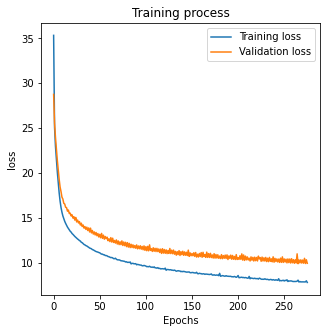

In [45]:
show_training_process(history=model_history, metric_name='loss',
                      figure_id=1)

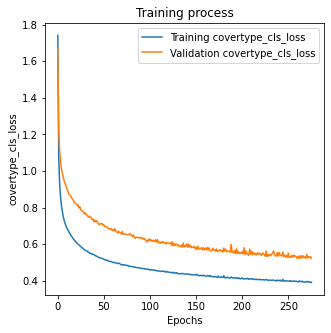

In [46]:
show_training_process(history=model_history, metric_name='covertype_cls_loss',
                      figure_id=2)

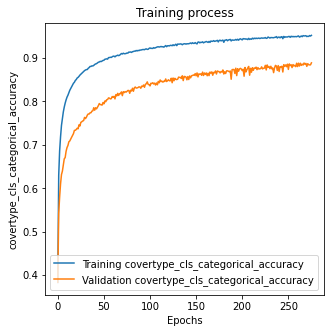

In [47]:
show_training_process(history=model_history,
                      metric_name='covertype_cls_categorical_accuracy',
                      figure_id=3)

In [48]:
del trainset_gen, validset_gen

In [49]:
del X_train, y_train, X_valid_quantized, X_train_quantized

In [50]:
del trainable_nn

In [51]:
gc.collect()

10210

In [52]:
valid_probas = predict_proba(
    X=X_valid, encoder=encoding_nn, classifier=classification_nn,
    n_samples=1, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/432 [00:00<?, ?it/s]

In [53]:
print(classification_report(y_true=y_valid, y_pred=np.argmax(valid_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.8952    0.8909    0.8930     10063
           1     0.9316    0.8661    0.8976     13457
           2     0.8922    0.9311    0.9112      1698
           3     0.5129    0.9667    0.6703       451
           4     0.7127    0.9382    0.8100       825
           5     0.7982    0.9867    0.8825       974
           6     0.7578    0.9313    0.8356       131

    accuracy                         0.8875     27599
   macro avg     0.7858    0.9301    0.8429     27599
weighted avg     0.8970    0.8875    0.8896     27599



In [54]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=1, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/454 [00:00<?, ?it/s]

In [55]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.8930    0.8875    0.8902     10592
           1     0.9294    0.8672    0.8972     14165
           2     0.8939    0.9279    0.9105      1788
           3     0.5326    0.9621    0.6857       475
           4     0.7044    0.9528    0.8100       868
           5     0.8099    0.9883    0.8903      1026
           6     0.7619    0.9343    0.8393       137

    accuracy                         0.8870     29051
   macro avg     0.7893    0.9314    0.8462     29051
weighted avg     0.8957    0.8870    0.8889     29051



In [ ]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=10, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

In [ ]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

In [ ]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=100, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

In [ ]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))